# Active learning example

In this example we show PyPAL can be used in conjunction with a "measure" function, mimicking a "real" active learning case.

In [8]:
from pypal import PALSklearn
import numpy as np 

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [5]:
def binh_korn(x, y):  # pylint:disable=invalid-name
    """https://en.wikipedia.org/wiki/Test_functions_for_optimization"""
    obj1 = 4 * x ** 2 + 4 * y ** 2
    obj2 = (x - 5) ** 2 + (y - 5) ** 2
    return -obj1, -obj2

def binh_korn_points():
    """Create a dataset based on the Binh-Korn test function"""
    x = np.linspace(0, 5, 100)  # pylint:disable=invalid-name
    y = np.linspace(0, 3, 100)  # pylint:disable=invalid-name
    array = np.array([binh_korn(xi, yi) for xi, yi in zip(x, y)])
    return np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)]), array

In [6]:
x, points = binh_korn_points()

## Implementing the "measure" function

In your real life example the `measure` function might be more complex and might involve an experiment or a long simulation. Here, we just return a value from a function.

In [17]:
def measure(index): 
    """Given the index of a point in the design matrix, return the measurement"""
    return points[index, :]

## Setting up the epsilon-PAL algorithm

Our example is two-dimensional. Hence, we will build two Gaussian process models.

In [90]:
# the regularization with alpha will make the process a bit slower, i.e., without regularization this model would classify all points with less than 5 iteration
model_objective_0 = GaussianProcessRegressor(kernel=RBF(), alpha=1e-5, normalize_y=True, n_restarts_optimizer=10)
model_objective_1 = GaussianProcessRegressor(kernel=RBF(), alpha=1e-5, normalize_y=True, n_restarts_optimizer=10)

Given these models, and the design matrix `x` we can construct our PAL instance.

In [91]:
# again, we choose conservative settings: a larger epsilon and a smaller beta_scale should make the code go faster
palinstance = PALSklearn(x, [model_objective_0, model_objective_1], 2, epsilon=0.01, beta_scale=1/3)

 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/PythonPAL/pypal/pal/validate_inputs.py:117: UserWarning:Only one epsilon value provided,             will automatically expand to use the same value in every dimension
 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/PythonPAL/pypal/pal/validate_inputs.py:145: UserWarning:No goals provided, will assume that every dimension should be maximized


Before we can handover the work to a loop we need to initialize the `palinstance` with some measurement. Often, a diverse set is the best choice and PyPAL provides an utilities to calculate this set (`get_kmeans_samples`, `get_maxmin_samples`). Here, we will use a greedy sampling of the farthest points in design space, initialized with the mean and using the Euclidean distance as distance metric (these are the defaults).

In [92]:
from pypal import get_maxmin_samples

In [93]:
indices = get_maxmin_samples(x, 5)

In [94]:
palinstance.update_train_set(indices, measure(indices))

## Running the search

In [95]:
while sum(palinstance.unclassified) > 0: 
    new_index = palinstance.run_one_step()
    print(palinstance) # the string representation of the object will give basic information about the state
    # if there is nothing to sample left, run_one_step() will return None
    if new_index is not None: 
        palinstance.update_train_set(new_index, measure(new_index))
    else: 
        break

 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/PythonPAL/pypal/pal/pal_base.py:345: UserWarning:The mean absolute error in crossvalidation is 6.31,
the mean variance is 5.46.
Your model might not be predictive and/or overconfident.
In the docs, you find hints on how to make GPRs more robust.


pypal at iteration 2.         0 Pareto optimal points,         0 discarded points,         100 unclassified points.
pypal at iteration 3.         0 Pareto optimal points,         0 discarded points,         100 unclassified points.
pypal at iteration 4.         6 Pareto optimal points,         0 discarded points,         94 unclassified points.
pypal at iteration 5.         9 Pareto optimal points,         0 discarded points,         91 unclassified points.
pypal at iteration 6.         10 Pareto optimal points,         0 discarded points,         90 unclassified points.
pypal at iteration 7.         13 Pareto optimal points,         0 discarded points,         87 unclassified points.
pypal at iteration 8.         22 Pareto optimal points,         0 discarded points,         78 unclassified points.
pypal at iteration 9.         24 Pareto optimal points,         0 discarded points,         76 unclassified points.
pypal at iteration 10.         25 Pareto optimal points,         0 discard

## Analyze the results

In PyPAL we provide some utilities that should help with analyzing the active learning process.

In [96]:
from pypal.plotting import make_jointplot

 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/PythonPAL/pypal/plotting/__init__.py:193: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/PythonPAL/pypal/plotting/__init__.py:194: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


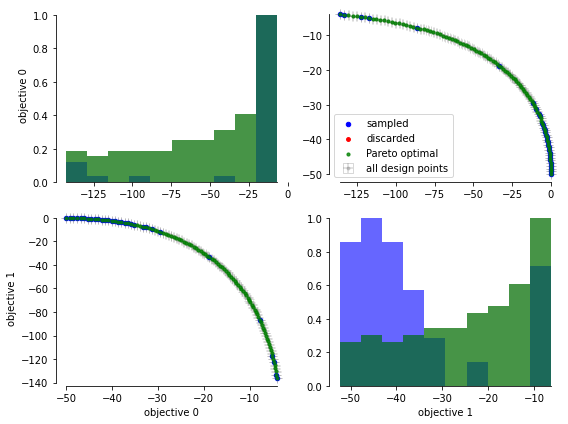

In [97]:
fig = make_jointplot(palinstance.means, palinstance)

We see that the algorithm did not discard any point and focussed on sampling the edges of the objective space. Also, our model recovered the correct shape of the test function.
We can verify it by making the same plot with the actual objective values (and not the predictions of the model). 

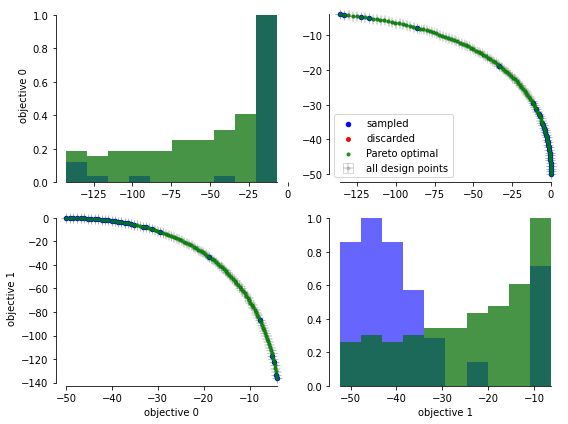

In [98]:
fig = make_jointplot(points, palinstance)

To estimate the quality of the Pareto frontier, you might want to measure the hypervolume of the points that were classified as Pareto optimal. As reference for integration, we choose the point (-100, -100).

In [99]:
from pypal import get_hypervolume

In [100]:
get_hypervolume(palinstance.means[palinstance.pareto_optimal], np.array([-100,-100]))

9061.973553968432